In [1]:
%pip install git+https://github.com/yfukai/BaSiCPy@autosegment

  Cloning https://github.com/yfukai/BaSiCPy (to revision autosegment) to /tmp/pip-req-build-o9v8r1e7
  Running command git clone --filter=blob:none --quiet https://github.com/yfukai/BaSiCPy /tmp/pip-req-build-o9v8r1e7
  Running command git checkout -b autosegment --track origin/autosegment
  Switched to a new branch 'autosegment'
  Branch 'autosegment' set up to track remote branch 'autosegment' from 'origin'.
  Resolved https://github.com/yfukai/BaSiCPy to commit a299f6e78ab7e5a3a20bba569581a4d8bd6256a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib ray

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

In [4]:
import ray
ray.shutdown()
ray.init(num_cpus=20)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-06 10:57:29,225	WARNING services.py:1826 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=10.24gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2023-07-06 10:57:30,411	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.10.8
Ray version:,2.5.1


In [5]:
from tqdm import tqdm
def to_iterator(obj_ids):
    while obj_ids:
        done, obj_ids = ray.wait(obj_ids)
        yield ray.get(done[0])
        
def show_ray_progress(res):
    for x in tqdm(to_iterator(res), total=len(res)):
        pass
    return ray.get(res)

In [6]:
workdir = "/work/fukai/basicpy"
os.makedirs(workdir,exist_ok = True)

In [7]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
import jax
#jax.config.update('jax_platform_name', 'cpu')

gpu


In [19]:
import numpy as np
import pandas as pd
from basicpy import BaSiC, datasets
from itertools import product
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle 
from os import path
from skimage import filters

plt.rcParams["font.family"] = ""

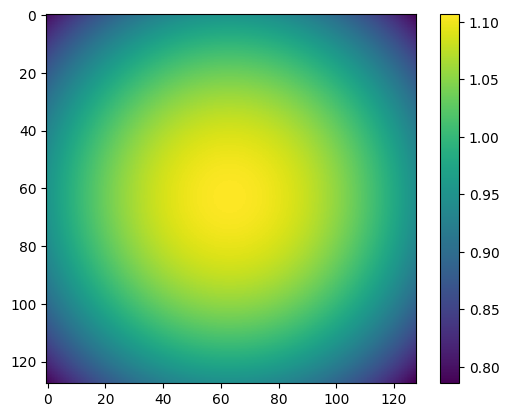

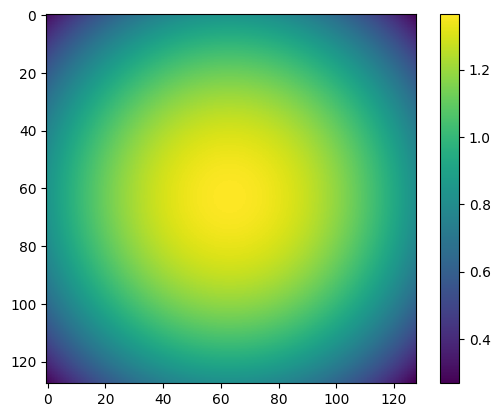

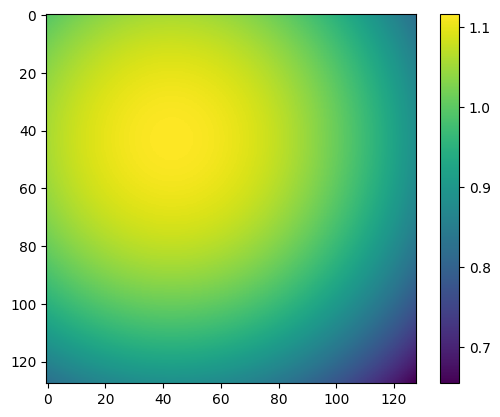

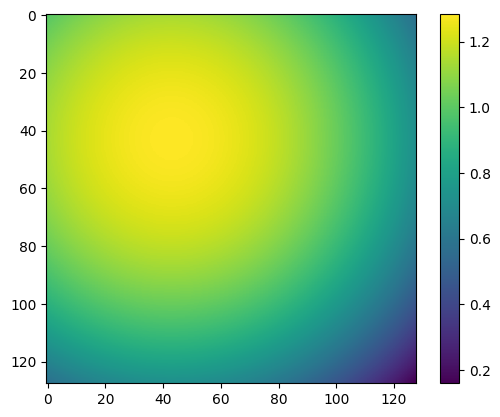

In [9]:
def generate_parabola(dim, coef, center):
    sizes = [128] * dim
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1 - c, size // 2 - c, size)
                for (c, size) in zip(center, sizes)
            ],
            indexing="ij"
        )
    )
    gradient = np.sum(grid**2, axis=0)
    gradient = coef * (np.max(gradient) - gradient) + 10
    return gradient / gradient.mean()


# Ground truth, for correctness checking

params = [
    (2, 0.0005, (0, 0)),
    (2, 0.005, (0, 0)),
    (2, 0.0005, (-20, -20)),
    (2, 0.005, (-20, -20)),
]

flatfield_profiles = [generate_parabola(*ps) for ps in params]

for p in flatfield_profiles:
    plt.imshow(p)
    plt.colorbar()
    plt.show()

# See how random out-of-flatfield objects affect the estimation

aim ... add random (uncorrelated) object that show intensity profile different from the fitted flatfield, see how it affects the fitting quality

## Flatfield only cases

In [10]:
blob_size = 2
blob_dist = lambda: np.random.normal(0, 2)

### single image test 

In [36]:
def generate_cluttered_images(
    true_flatfield, intensity, n_images, ave_count, blob_dist
):
    poss = np.array(
        [
            [
                np.random.uniform(
                    -size // 2 + 1,
                    size // 2,
                )
                for size in true_flatfield.shape
            ]
            for _ in range(np.random.poisson(ave_count))
        ]
    )

    images = []
    grid = np.array(
        np.meshgrid(
            *[
                np.linspace(-size // 2 + 1, size // 2, size)
                for size in true_flatfield.shape
            ],
            indexing="ij"
        )
    )
    for _ in range(n_images):
        image = true_flatfield.copy()
        for p in poss:
            image += (
                np.exp(
                    -np.sum((grid - p[:, np.newaxis, np.newaxis]) ** 2, axis=0)
                    / 2.0
                    / blob_size**2
                )
                / np.sqrt(2 * np.pi * blob_size**2) ** 2
                * blob_dist()
            )
        image = image * intensity
        image = np.clip(image, 0, None)
        image = filters.gaussian(np.random.poisson(image),sigma=1,preserve_range=True)
        images.append(image)
    return np.array(images)

(raylet) [2023-07-06 19:52:04,307 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 6784868352; capacity: 464773414912. Object creation will fail if spilling is required.


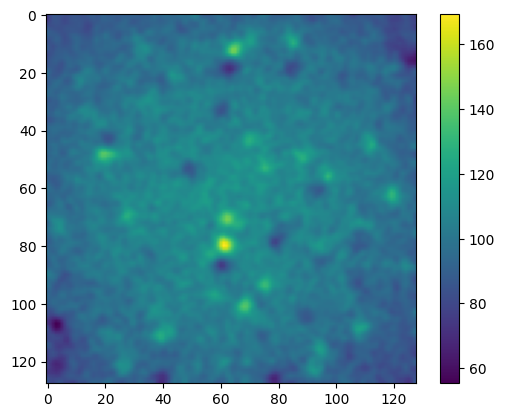

In [37]:
images = generate_cluttered_images(
    flatfield_profiles[0], 100, 100, 100, lambda: np.random.normal(0, 5)
)
plt.imshow(images[0])
plt.colorbar()

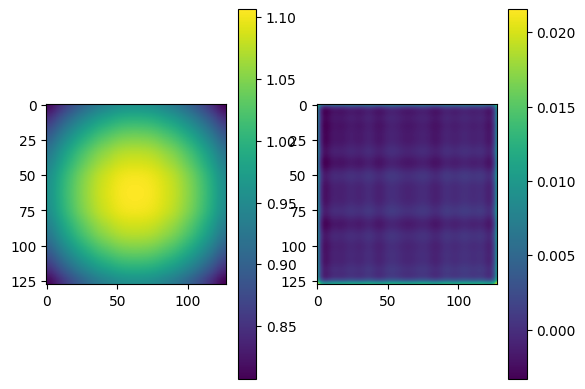

In [39]:
b = BaSiC(get_darkfield=False)
b.fit(np.array(images))
plt.subplot(121)
plt.imshow(b.flatfield)
plt.colorbar()
plt.subplot(122)
plt.imshow(b.flatfield / np.mean(b.flatfield) - flatfield_profiles[0])
plt.colorbar()

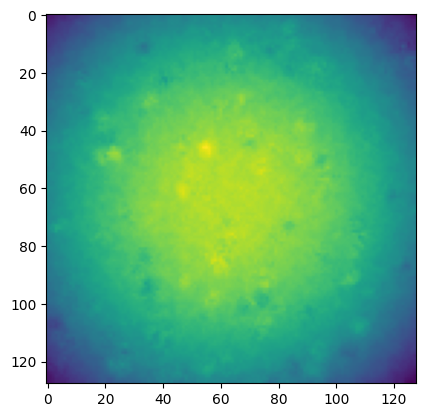

(raylet) [2023-07-06 19:52:14,316 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 6772355072; capacity: 464773414912. Object creation will fail if spilling is required.


In [40]:
plt.imshow(np.median(images, axis=0))

### fit multiple images 

In [41]:
np.random.seed(202306)
repeat = 100
blob_dists = {
    "unbiased": lambda: np.random.normal(0, 5),
    "biased": lambda: np.random.normal(10, 5),
}
conditions = list(
    product(
        range(
            len(flatfield_profiles)
        ),  # true_flatfield_id (index of flatfield_profiles)
        [10, 100, 1000],  # intensity
        [10, 100],  # ave_count
        [10, 30, 100, 300, 1000],  # n_images
        ["biased", "unbiased"],  # blob_dist_key
        range(5)
    )
)

parameters = []
imagess = []
for (
    true_flatfield_id,
    intensity,
    ave_count,
    n_images,
    blob_dist_key,
    rep
) in tqdm(conditions):
    p = {
            "true_flatfield_id": true_flatfield_id,
            "intensity": intensity,
            "ave_count": ave_count,
            "n_images": n_images,
            "blob_dist_key": blob_dist_key,
            "rep":rep,
            }
    parameters.append(
        p
    )
    imagess.append(generate_cluttered_images(
        flatfield_profiles[true_flatfield_id],
        intensity=intensity,
        n_images=n_images,
        ave_count=ave_count,
        blob_dist=blob_dists[blob_dist_key],
    ))

  7%|██████▎                                                                                  | 85/1200 [03:01<2:51:36,  9.23s/it](raylet) [2023-07-06 19:55:24,532 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 6684377088; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 19:55:34,544 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 6684311552; capacity: 464773414912. Object creation will fail if spilling is required.
  8%|██████▋                                                                                  | 90/1200 [03:50<2:54:43,  9.44s/it](raylet) [2023-07-06 19:56:14,592 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 6683377664; capacity: 464773414912. Object c

In [42]:
#show_ray_progress(imagess)

In [43]:
#imagess = ray.get(imagess)

In [44]:
with open(path.join(workdir,"wo_darkfield_imagess.pickle"),"wb") as f:
    pickle.dump(imagess,f)

(raylet) [2023-07-06 21:45:52,554 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4925702144; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:46:02,562 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4925743104; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:46:12,574 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4925677568; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:46:22,584 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4925743104; capacity: 464773414912. Object 

In [45]:
with open(path.join(workdir,"wo_darkfield_imagess.pickle"),"rb") as f:
    imagess=pickle.load(f)

(raylet) [2023-07-06 21:47:32,672 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4923531264; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:47:42,678 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4923531264; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:47:52,686 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4923531264; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:48:02,696 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4923465728; capacity: 464773414912. Object 

In [46]:
pd.DataFrame.from_records(parameters).to_csv(path.join(workdir,"wo_darkfield_parameters.csv"))

In [47]:
!ls $workdir

wo_darkfield_imagess.pickle  wo_darkfield_parameters.csv


(raylet) [2023-07-06 21:48:12,705 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4923465728; capacity: 464773414912. Object creation will fail if spilling is required.


In [48]:
parameters_df=pd.read_csv(path.join(workdir,"wo_darkfield_parameters.csv"))

In [49]:
jax.config.update('jax_platform_name', 'gpu')

In [50]:
#parameters_df = pd.DataFrame.from_records(parameters)
#ind = (parameters_df["n_images"]<900).values
#parameters_df2 = parameters_df[ind].copy()
#imagess2 = [imagess[ii] for ii in np.nonzero(ind)[0]]
"""
assert len(parameters_df2) == len(imagess2)
with open("wo_darkfield_imagess2.pickle","wb") as f:
    pickle.dump(imagess2,f)
parameters_df2.to_csv("wo_darkfield_parameters2.csv")
"""

'\nassert len(parameters_df2) == len(imagess2)\nwith open("wo_darkfield_imagess2.pickle","wb") as f:\n    pickle.dump(imagess2,f)\nparameters_df2.to_csv("wo_darkfield_parameters2.csv")\n'

In [ ]:
flatfields = []
baselines = []
b = BaSiC(
    get_darkfield=False,
)

def fit_basic(i,imagess):
    images 

for p,images in tqdm(zip(parameters_df.to_dict(orient="records"),imagess),total=len(imagess)):
    for fitting_mode, smoothness_flatfield in product(
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-3, 1, 7)),  # smoothness_flatfield
    ):
        p2 = p.copy()
        p2.update({
            "fitting_mode": fitting_mode,
            "smoothness_flatfield": smoothness_flatfield,
        })
        b.fitting_mode=fitting_mode
        b.smoothness_flatfield=smoothness_flatfield
        b.fit(images)
        flatfields.append(b.flatfield)
        baselines.append(b.baseline)

  0%|▏                                                                                       | 3/1200 [00:37<4:07:09, 12.39s/it](raylet) [2023-07-06 21:48:52,745 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4921262080; capacity: 464773414912. Object creation will fail if spilling is required.
(raylet) [2023-07-06 21:49:02,755 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4921282560; capacity: 464773414912. Object creation will fail if spilling is required.
  1%|▋                                                                                       | 9/1200 [01:49<4:00:19, 12.11s/it](raylet) [2023-07-06 21:50:02,817 E 239273 239293] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-07-06_10-57-27_148079_239040 is over 95% full, available space: 4916940800; capacity: 464773414912. Object creat

In [ ]:
np.save("flatfields.npy",flatfields)

In [ ]:
flatfields = np.load("flatfields.npy")

In [ ]:
estimated_parameters = []
for p,images in tqdm(zip(parameters_df.to_dict(orient="records"),imagess),total=len(imagess)):
    for fitting_mode, smoothness_flatfield in product(
        ["ladmap", "approximate"],  # fitting_mode
        list(np.logspace(-3, 1, 15)),  # smoothness_flatfield
    ):
        p2 = p.copy()
        p2.update({
            "fitting_mode": fitting_mode,
            "smoothness_flatfield": smoothness_flatfield,
        })
        estimated_parameters.append(p2)
estimated_parameters_df = pd.DataFrame.from_records(estimated_parameters).reset_index(drop=True)

In [ ]:
assert len(estimated_parameters_df) == len(flatfields)

In [ ]:
for (i, row), flatfield in zip(estimated_parameters_df.iterrows(),flatfields):
    estimated_parameters_df.loc[i,"deviation"] = np.mean(np.abs(flatfield - flatfield_profiles[row["true_flatfield_id"]]))

In [ ]:
if "Unnamed: 0" in estimated_parameters_df.keys():
    del estimated_parameters_df["Unnamed: 0"]

In [ ]:
estimated_parameters_df.to_csv("wo_flatfield_estimated_parameters_df.csv")
estimated_parameters_df.head()

In [ ]:
estimated_parameters_df = pd.read_csv("wo_flatfield_estimated_parameters_df.csv")

In [ ]:
estimated_parameters_df.keys()

In [ ]:
res_dir = "figs/wo_darkfields/"
os.makedirs(res_dir,exist_ok=True)

In [ ]:
for (intensity, ave_count, n_images, blob_dist_key), grp in tqdm(estimated_parameters_df.groupby(["intensity", "ave_count", "n_images","blob_dist_key"])):
    df = grp[grp["rep"]==0]
    smoothness_flatfields=df["smoothness_flatfield"].unique()
    ncol = len(smoothness_flatfields)
    nrow = int(len(df) / ncol)
    fig, axes = plt.subplots(nrow,ncol, figsize=(2*ncol,2*nrow))
    for irow, ((fitting_mode, true_flatfield_id), grp2) in enumerate(df.groupby(["fitting_mode","true_flatfield_id"])):
        df2=grp2.sort_values(["smoothness_flatfield",])
        assert len(axes[irow,:]) == len(df2)
        for ax, (j, row) in zip(axes[irow,:],df2.iterrows()):
            ax.imshow(flatfields[j])
            #ax.axis("off")
        axes[irow,0].set_ylabel(f"{fitting_mode}\nflatfield #{true_flatfield_id}",rotation=90)
    fig.tight_layout()
    fig.savefig(os.path.join(res_dir,f"{fitting_mode}_flatfield_{true_flatfield_id}.png"),bbox_inches="tight")
    break

## Including darkfield